In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.gmm import IV2SLS
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt

# Analysis of Advertising Impact on User Engagement in Pandora

This project aims to analyze the effects of advertising on user engagement in the Pandora music streaming service by utilizing a simulated dataset inspired by the Pandora Listener Demand Paper ("https://www.davidreiley.com/papers/PandoraListenerDemandCurve.pdf"). The project examines various aspects of treatment effects, including dosage, time variation, non-compliance handling through instrumental variables, and heterogeneous treatment effects across different user demographics.

The project is divided into four primary problems, each focusing on different analytical aspects:

###Investigating Dosage Effects:

Analyzing the impact of varying ad load on user engagement by comparing control and treatment groups using statistical tests and regression analysis.

###Temporal Treatment Effects:

Examining how the effectiveness of ad treatments evolves over time, assessing when treatment effects stabilize and their statistical significance.

###Handling Non-compliance:

Utilizing instrumental variable techniques to address discrepancies in actual ad load versus intended ad load, providing a more robust estimate of the treatment effect on user engagement.

###Heterogeneous Treatment Effects:

Exploring differences in treatment effects across various demographic subgroups (e.g., age groups), identifying if certain groups respond differently to ad exposure.

##Instrumental Variables (IV) Analysis to Address Compliance:
A core component of this project is handling the difference between intended and actual ad dosage. Using IV2SLS (Instrumental Variables 2-Stage Least Squares), I address non-compliance by instrumenting the actual ad load with intended ad dosage. First, I estimate the relationship between intended and actual ad load, examining instrument strength through the R-squared value. Then, I use IV2SLS, treating "treated_ad_min" as an instrument for "ad_min_actual", obtaining an unbiased estimate of the impact of ad dosage on engagement. The IV2SLS results are compared to OLS findings to highlight any discrepancies due to endogenous variation in actual ad load.



In [ ]:
df = pd.read_csv('/content/pandora_ad_data.csv')

df.head()

,Unnamed: 0,user_id,city,sex,age,cell,week,interruptions,ads_per,ad_min_actual,play_min
0,0,0,Los Angeles,F,18-24,8,0,9,1.5,8.502471,0.000000
1,1,0,Los Angeles,F,18-24,8,1,9,1.5,3.879412,0.000000
2,2,0,Los Angeles,F,18-24,8,2,9,1.5,5.923588,0.000000
3,3,0,Los Angeles,F,18-24,8,3,9,1.5,5.110541,434.683385
4,4,0,Los Angeles,F,18-24,8,4,9,1.5,3.964341,0.000000


In [ ]:
last_week = df['week'].max()
df_end = df[df['week'] == last_week]

num_weeks = df['week'].nunique()
print(f"There are {num_weeks} weeks in the experiment.")

users_per_week = df.groupby('week')['user_id'].nunique()
print(users_per_week)

There are 112 weeks in the experiment.
week
0      48000
1      48000
2      48000
3      48000
4      48000
       ...  
107    48000
108    48000
109    48000
110    48000
111    48000
Name: user_id, Length: 112, dtype: int64


In [ ]:
control_group = df_end[df_end['cell'] == 0]

for cell in range(1, 10):
    treatment_group = df_end[df_end['cell'] == cell]
    t_stat, p_value = ttest_ind(control_group['play_min'], treatment_group['play_min'])

    # Determine significance based on p-value
    significance = "Significant" if p_value < 0.05 else "Not Significant"

    print(f"Cell {cell} vs Control (Cell 0): t-stat = {t_stat:.3f}, p-value = {p_value:.3f} ({significance})")

Cell 1 vs Control (Cell 0): t-stat = -0.987, p-value = 0.324 (Not Significant)
Cell 2 vs Control (Cell 0): t-stat = -0.038, p-value = 0.970 (Not Significant)
Cell 3 vs Control (Cell 0): t-stat = 0.169, p-value = 0.866 (Not Significant)
Cell 4 vs Control (Cell 0): t-stat = -0.330, p-value = 0.742 (Not Significant)
Cell 5 vs Control (Cell 0): t-stat = 0.292, p-value = 0.771 (Not Significant)
Cell 6 vs Control (Cell 0): t-stat = 1.467, p-value = 0.142 (Not Significant)
Cell 7 vs Control (Cell 0): t-stat = 0.661, p-value = 0.509 (Not Significant)
Cell 8 vs Control (Cell 0): t-stat = 3.667, p-value = 0.000 (Significant)
Cell 9 vs Control (Cell 0): t-stat = 3.361, p-value = 0.001 (Significant)


In [ ]:
df_end['treated_ad_min'] = df_end['interruptions'] * df_end['ads_per'] * 0.5
df_end[['interruptions', 'ads_per', 'treated_ad_min']].head()

model_1c = smf.ols('play_min ~ treated_ad_min', data=df_end).fit()
print(model_1c.summary())

                            OLS Regression Results                            
Dep. Variable:               play_min   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     26.15
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           3.17e-07
Time:                        19:22:32   Log-Likelihood:            -3.4625e+05
No. Observations:               48000   AIC:                         6.925e+05
Df Residuals:                   47998   BIC:                         6.925e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        359.1091      4.265     84.

<ipython-input-5-85942a7a9a89>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end['treated_ad_min'] = df_end['interruptions'] * df_end['ads_per'] * 0.5


In [ ]:
df['treated_ad_min'] = df['interruptions'] * df['ads_per'] * 0.5

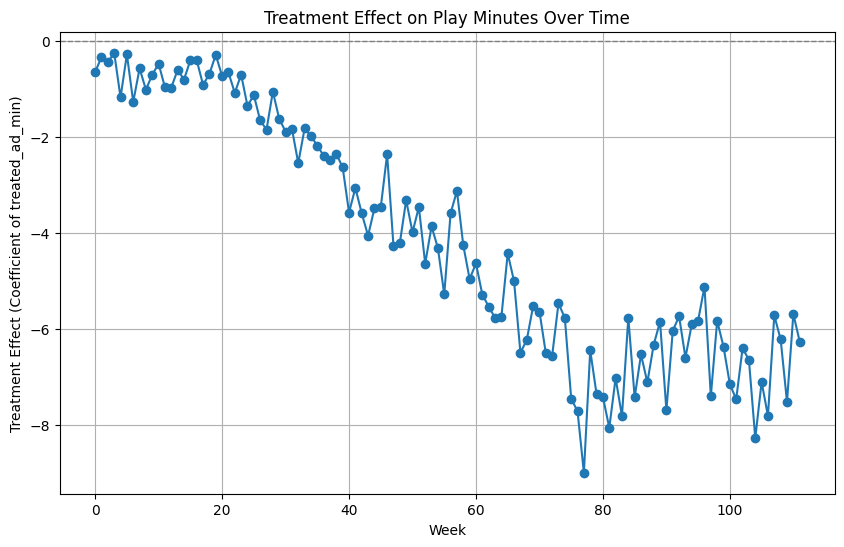

The treatment effect stabilizes at week 12 with a value of -0.97.


In [ ]:
weeks = df['week'].unique()
treatment_effects = []

for week in weeks:
    df_week = df[df['week'] == week]
    model = smf.ols('play_min ~ treated_ad_min', data=df_week).fit()
    treatment_effects.append(model.params['treated_ad_min'])

plt.figure(figsize=(10, 6))
plt.plot(weeks, treatment_effects, marker='o')
plt.title('Treatment Effect on Play Minutes Over Time')
plt.xlabel('Week')
plt.ylabel('Treatment Effect (Coefficient of treated_ad_min)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid()
plt.show()

stable_effect = None
for i in range(1, len(treatment_effects)):
    if abs(treatment_effects[i] - treatment_effects[i-1]) < 0.01:
        stable_effect = treatment_effects[i]
        break

print(f"The treatment effect stabilizes at week {weeks[i]} with a value of {stable_effect:.2f}.")

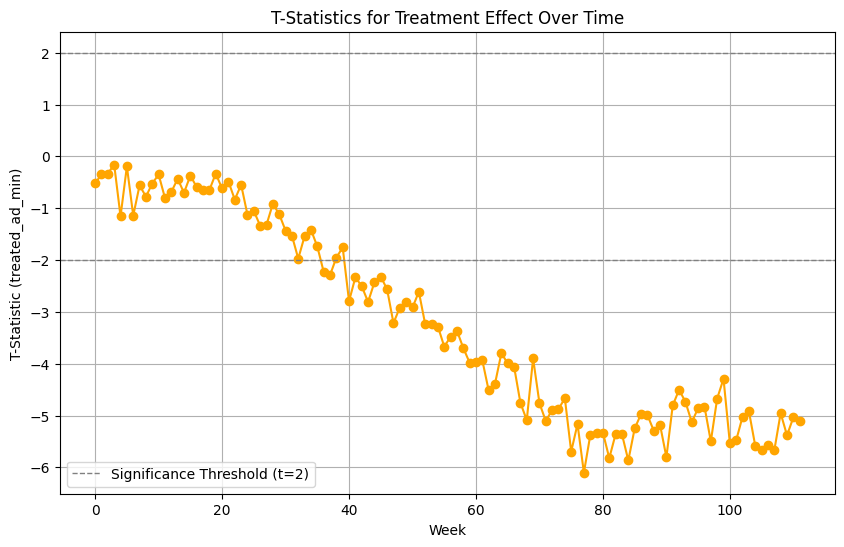

The first week the treatment effect is statistically significant is week 36.


In [ ]:
t_stats = []

for week in weeks:
    df_week = df[df['week'] == week]
    model = smf.ols('play_min ~ treated_ad_min', data=df_week).fit()

    t_stats.append(model.tvalues['treated_ad_min'])

plt.figure(figsize=(10, 6))
plt.plot(weeks, t_stats, marker='o', color='orange')
plt.title('T-Statistics for Treatment Effect Over Time')
plt.xlabel('Week')
plt.ylabel('T-Statistic (treated_ad_min)')
plt.axhline(2, color='gray', linestyle='--', linewidth=1, label='Significance Threshold (t=2)')
plt.axhline(-2, color='gray', linestyle='--', linewidth=1)
plt.grid()
plt.legend()
plt.show()

first_significant_week = None
for i, t_stat in enumerate(t_stats):
    if abs(t_stat) > 2:
        first_significant_week = weeks[i]
        break

print(f"The first week the treatment effect is statistically significant is week {first_significant_week}.")

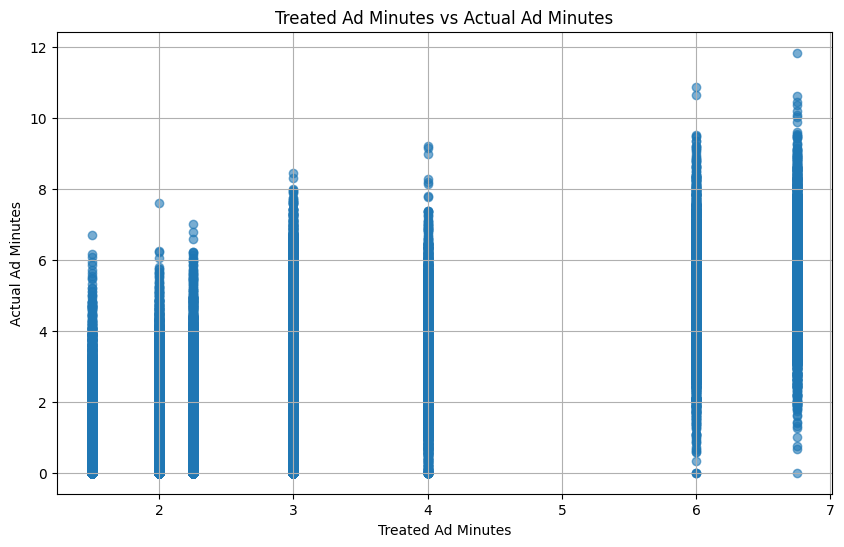

   treated_ad_min  ad_min_actual
0            1.50       1.360815
1            2.00       1.737821
2            2.25       1.876501
3            3.00       2.487349
4            4.00       3.361121
5            6.00       4.963919
6            6.75       5.611792


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_end['treated_ad_min'], df_end['ad_min_actual'], alpha=0.6)
plt.title('Treated Ad Minutes vs Actual Ad Minutes')
plt.xlabel('Treated Ad Minutes')
plt.ylabel('Actual Ad Minutes')
plt.grid()
plt.show()

mean_ad_load = df_end.groupby('treated_ad_min')['ad_min_actual'].mean().reset_index()

print(mean_ad_load)

In [ ]:
model_3b_i = smf.ols('ad_min_actual ~ treated_ad_min', data=df_end).fit()
print(model_3b_i.summary())

coef_treated_ad_min = model_3b_i.params['treated_ad_min']
r_squared = model_3b_i.rsquared

print(f"Coefficient on treated_ad_min: {coef_treated_ad_min:.2f}")
print(f"R-squared: {r_squared:.2f}")

model_3b_ii = smf.ols('play_min ~ treated_ad_min', data=df_end).fit()

print(model_3b_ii.summary())

coef_play_min = model_3b_ii.params['treated_ad_min']
print(f"Coefficient on treated_ad_min in play_min model: {coef_play_min:.2f}")

ratio = coef_play_min / coef_treated_ad_min
print(f"The ratio of the coefficients (play_min to ad_min_actual) is: {ratio:.2f}")

                            OLS Regression Results                            
Dep. Variable:          ad_min_actual   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                 2.234e+04
Date:                Mon, 07 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:22:46   Log-Likelihood:                -86602.
No. Observations:               48000   AIC:                         1.732e+05
Df Residuals:                   47998   BIC:                         1.732e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0449      0.019      2.

In [ ]:
df_end_copy = df_end.copy()
df_end_copy['constant'] = 1

x= df_end_copy[['ad_min_actual', 'constant']]
y= df_end_copy[['play_min']]
z= df_end_copy[['treated_ad_min', 'constant']]

iv_model = IV2SLS(y, x, instrument=z).fit()

coeff_2sls_iv = iv_model.params['ad_min_actual']

p_value_2sls_iv = iv_model.pvalues['ad_min_actual']

print(f"Coefficient from 2SLS: {coeff_2sls_iv:.2f}")
print(f"P-value from 2SLS: {p_value_2sls_iv:.2f}")
print(iv_model.summary())

Coefficient from 2SLS: -7.65
P-value from 2SLS: 0.00
                          IV2SLS Regression Results                           
Dep. Variable:               play_min   R-squared:                       0.011
Model:                         IV2SLS   Adj. R-squared:                  0.011
Method:                     Two Stage   F-statistic:                     26.42
                        Least Squares   Prob (F-statistic):           2.76e-07
Date:                Mon, 07 Oct 2024                                         
Time:                        19:22:46                                         
No. Observations:               48000                                         
Df Residuals:                   47998                                         
Df Model:                           1                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [ ]:
model_4a = smf.ols('play_min ~ treated_ad_min * age', data=df_end).fit()
print(model_4a.summary())

                            OLS Regression Results                            
Dep. Variable:               play_min   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     763.6
Date:                Mon, 07 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:22:46   Log-Likelihood:            -3.4373e+05
No. Observations:               48000   AIC:                         6.875e+05
Df Residuals:                   47992   BIC:                         6.875e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

The treatment effect (how ad minutes affect play minutes) is not the same across age groups.
The strongest (and statistically significant) effect is observed for age 25-54, where an increase in ad minutes significantly reduces play minutes.
The effects for age groups 18-24 and 55+ are not statistically significant at the 95% level.

In [ ]:
model_4b = smf.ols('ad_min_actual ~ treated_ad_min * age', data=df_end).fit()
print(model_4b.summary())

                            OLS Regression Results                            
Dep. Variable:          ad_min_actual   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     3884.
Date:                Mon, 07 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:22:47   Log-Likelihood:                -85000.
No. Observations:               48000   AIC:                         1.700e+05
Df Residuals:                   47992   BIC:                         1.701e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [ ]:

coeff_2sls={}
reduced_coeff_2sls={}
df_end_copy = df_end.copy()

df_end_copy['constant'] = 1
age_groups = df_end_copy['age'].unique()

results_3c = {}

for age in age_groups:
    df_age_group = df_end_copy[df_end_copy['age'] == age]
    x= df_age_group[['ad_min_actual', 'constant']]
    y= df_age_group[['play_min']]
    z= df_age_group[['treated_ad_min', 'constant']]

    iv_model = IV2SLS(y, x, instrument=z).fit()
    results_3c[age] = iv_model
    coeff_2sls[age] = iv_model.params['ad_min_actual']

    reduced_model= smf.ols(formula= 'ad_min_actual~ treated_ad_min', data= df_age_group).fit()
    reduced_coeff_2sls[age] = reduced_model.params['treated_ad_min']

print("Coefficients from 2SLS:")
for age, coeff in coeff_2sls.items():
    print(f"Age Group: {age}, Coefficient: {coeff}")

print("\nCoefficients from Reduced Form:")
for age, coeff in reduced_coeff_2sls.items():
    print(f"Age Group: {age}, Coefficient: {coeff}")

change_effect = {age: coeff_2sls[age] - reduced_coeff_2sls[age] for age in age_groups}
largest_change_group= max(change_effect, key=change_effect.get)
print(f"\nThe group with the largest change in treatment effect is: {largest_change_group}")


Coefficients from 2SLS:
Age Group: 18-24, Coefficient: -8.567786975009275
Age Group: 25-54, Coefficient: -10.611313794814404
Age Group: 55+, Coefficient: -4.828340519581552
Age Group: 13-17, Coefficient: -2.107380329960197

Coefficients from Reduced Form:
Age Group: 18-24, Coefficient: 0.8347666029822348
Age Group: 25-54, Coefficient: 0.8286141539289207
Age Group: 55+, Coefficient: 0.7937118101141775
Age Group: 13-17, Coefficient: 0.8041581230050379

The group with the largest change in treatment effect is: 13-17
